In [1]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# PG Bookshelves
We use PG bookshelves as labels, see here [here](http://www.gutenberg.org/wiki/Category:Bookshelf).
They are better than the 'genre' metadata field. **WHY???**
## Getting the data
We scrap the PG wiki with `wget`,
```bash
wget --random-wait -r -p --no-parent -e robots=off -U mozilla http://www.gutenberg.org/wiki/Category:Bookshelf
```
see `data/bookshelves/README.md` for details. Then we parse the html files with `lxml`

In [2]:
import lxml.html

In [3]:
BS_paths = glob.glob("../data/bookshelves/*Bookshelf*")
BS = [path.split("/")[-1] for path in BS_paths]

In [4]:
BS_dict = {}
for path in BS_paths:
    bs = path.split("/")[-1]
    BS_dict[bs] = []
    with open(path, "r") as foo:
        dom = lxml.html.fromstring(foo.read())
        # select the url in href for all a tags(links)
        for link in dom.xpath('//a/@href'):
            # links to ebooks that are not searches
            if link.find("ebooks")>-1 and link.find("search")==-1:
                PGid = "PG"+link.split("/")[-1]
                BS_dict[bs].append(PGid)

    # delete empty BSs
    if len(BS_dict[bs])==0:
        del BS_dict[bs]
    
# recompose list of BSs
BS = list(BS_dict.keys())

# list of unique PGids
PGids = list(set(np.concatenate(list(BS_dict.values()))))

And save the data into a pickled dataframe

In [5]:
# put in a DataFrame
df = pd.DataFrame(index = PGids, columns = BS)
for k,v in BS_dict.items():
    df.loc[v, k] = True

In [6]:
df.to_pickle("../data/bookshelves_raw.p")

## Filtering by size
We focus on BS of medium size:

In [7]:
min_books = 50
max_books = 150

In [8]:
sdf = df.loc[:, (df.sum()>min_books) & (df.sum()<=max_books) ].dropna(how="all")

In [9]:
print(sdf.shape)

(4400, 53)


Which leaves us with 53 cathegories totalling 4400 books. This is a small, curated¿? subset of the total PG.

### Ovelaps
Of these 4400 books, only 257 appear in more than one bookshelves, spanning 42 out of 53 BS.
I think we have two options:
+ Leave them in
+ **Drop the books**

In [10]:
data = sdf.loc[sdf.sum(axis=1)>1].dropna(how="all", axis=1).fillna(0).astype(int)

In [11]:
print(data.shape)

(257, 42)


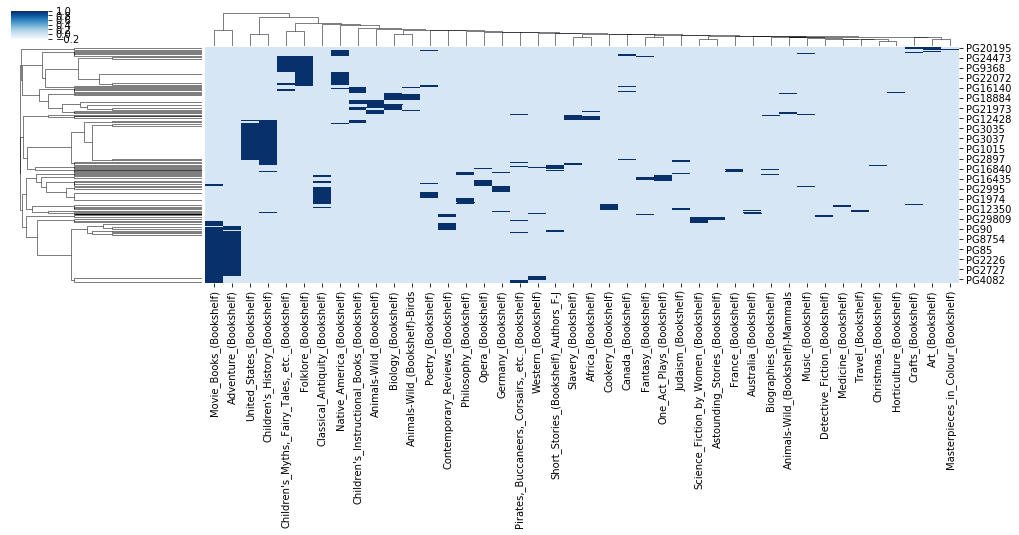

In [12]:
import seaborn as sns
sns.clustermap(data, cmap="Blues", vmin=-.2, figsize=(17,5))

So I decided to drop the 257 books for the moment:

In [13]:
sdf = sdf.loc[sdf.sum(axis=1)==1].dropna(how="all", axis=1)

In [14]:
print(sdf.shape)

(4143, 53)


Finally, we remove the *Esperanto* bookshelve

In [15]:
sdf = sdf.drop("Esperanto_(Bookshelf)", axis=1).dropna(how="all")

In [16]:
print(sdf.shape)

(4046, 52)


### Filter by language
We check if any of the remaining books are not written in English

In [17]:
import sys
sys.path.append("../../gutenberg/src/")

In [18]:
!ls ../../gutenberg/src/

cleanup.py   metadataparser.py	nltk_data    __pycache__   utils.py
__init__.py  metaquery.py	pipeline.py  tokenizer.py


In [19]:
from metaquery import meta_query

In [24]:
mq = meta_query(path="../../gutenberg/metadata/metadata.csv")

In [29]:
mq.filter_lang("en", how="only")

In [30]:
allPGs = mq.df.set_index("id").index

In [31]:
len(np.intersect1d(sdf.index, allPGs))

3695

So we further drop a few more books not written in English.
I suspect these were the outliers in the UMAP plots!

In [36]:
sdf = sdf.loc[np.intersect1d(sdf.index, allPGs)].dropna(how="all", axis=1).shape

(3695, 51)